In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits
import pysm3 as sm
from scipy.special import j1
from astropy import units as u
import healpy as hp
import sys
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as tck
import pickle
%matplotlib inline

In [2]:
nside = 256

In [3]:
summit_atmos = np.loadtxt('Summit_30deg_opening', skiprows=7)
sedgwick_atmos = np.loadtxt('sedgwick_30deg_opening', skiprows=7)
sea_level_atmos = np.loadtxt('sea_level_30deg_opening', skiprows=7)
high_altitude = np.loadtxt('35km', skiprows=7)

In [4]:
freq_summit = summit_atmos[:,0]
temp_summit = summit_atmos[:,2]

freq_sedgwick = sedgwick_atmos[:,0]
temp_sedgwick = sedgwick_atmos[:,2]

freq_sea_level = sea_level_atmos[:,0]
temp_sea_level = sea_level_atmos[:,2]

freq_high_altitude = high_altitude[:,0]
temp_high_altitude = high_altitude[:,2]

In [5]:
h = 6.62607015e-34
k = 1.380649e-23
ql = h*freq_summit*1e9/k

In [6]:
%%time
dust = sm.Sky(nside, preset_strings = ['d1'])
synch = sm.Sky(nside, preset_strings = ['s1'])
freefree = sm.Sky(nside, preset_strings = ['f1'])
ame = sm.Sky(nside, preset_strings = ['a1'])
cmb = sm.Sky(nside, preset_strings = ['c1'])

CPU times: user 26.9 s, sys: 1.06 s, total: 28 s
Wall time: 8.39 s


In [7]:
freqs = freq_summit * sm.units.GHz

In [8]:
%%time
Tmask = hp.read_map('COM_Mask_CMB-confidence-Tmask-IQU-commander-field-Int_2048_R2.01_full.fits')
Tmask = hp.ud_grade(Tmask, nside)

Pmask = hp.read_map('COM_Mask_CMB-confidence-Pmask-IQU-commander_1024_R2.02_full.fits')
Pmask = hp.ud_grade(Pmask, nside)

CPU times: user 3.79 s, sys: 1.18 s, total: 4.97 s
Wall time: 5.05 s


In [9]:
components = {'dust': dust, 'synch': synch, 'freefree': freefree, 'ame': ame, 'cmb':cmb}

In [10]:
%%time
componentsT = {}
componentsP = {}
i = 0
for k in components.keys():
    components_emission = components[k].get_emission(freqs[i])
    componentsT[k] = hp.smoothing(components_emission[0]*Tmask, np.radians(1))
    componentsQ = components_emission[1]
    componentsU = components_emission[2]
    componentsP[k] = hp.smoothing(np.sqrt((componentsQ)**2 + (componentsU)**2)*Pmask, np.radians(40./60.))
    
components2 = {'T': componentsT, 'P': componentsP}

CPU times: user 28.9 s, sys: 572 ms, total: 29.5 s
Wall time: 16.9 s


In [14]:
print('pixel area (deg^2): ', hp.nside2pixarea(256, degrees=True))

pixel area (deg^2):  0.052455852825697924


In [15]:
print('celestial sphere area:', hp.nside2pixarea(256, degrees=True)*hp.nside2npix(256)/1000)

celestial sphere area: 41.25296124941927


<Figure size 640x480 with 0 Axes>

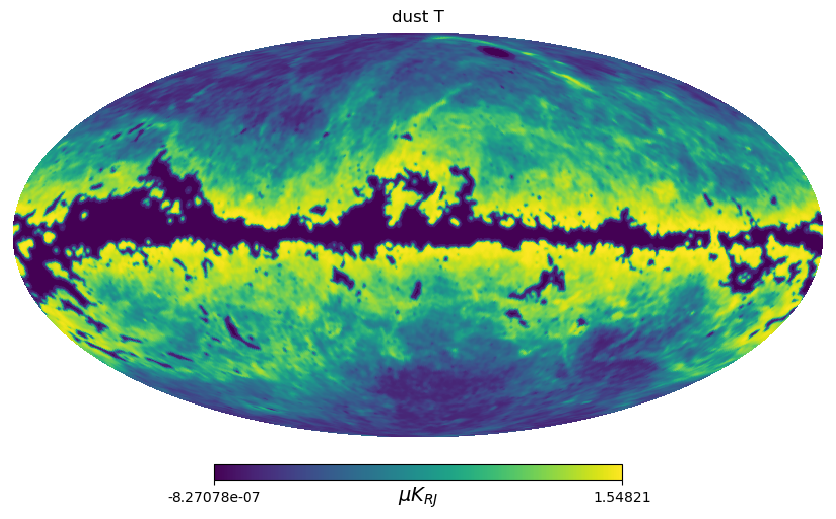

In [32]:
k = 'dust'
v = 'T'
plt.figure()
hp.mollview(components2[v][k], norm='hist', unit=r'$\mu K_{RJ}$', title=f'{k} {v}')
plt.show()

In [ ]:
'''%%time
spectrumT = {}
spectrumP = {}

for k in components.keys():
    T = []
    P = []
    print('\n ----')
    for i in range(len(freq_summit)):
        components_emission = components[k].get_emission(freqs[i])
        Tmean = np.sqrt(((hp.smoothing(components_emission[0]*Tmask, np.radians(1.)))**2).mean())
        #Qmean = components_emission[1]
        #Umean = components_emission[2]
        #Pmean = np.sqrt(((hp.smoothing((np.sqrt(Qmean**2 + Umean**2))*Pmask, np.radians(4./6.)))**2).mean())
        
        T.append(Tmean)
        #P.append(Umean)
        
        sys.stdout.write('\r %s, Percent complete: %.3f' % (k, 100*float(i)/len(freq_summit)))
        sys.stdout.flush()
        
    spectrumT[k] = np.asarray(T)
    #spectrumP[k] = P
    
    
spectrum2 = {'T': spectrumT, 'P': spectrumP}'''

In [ ]:
#pickle.dump(spectrum2, open( "spectrum.p", "wb" ) )

In [33]:
spectrum2 = pickle.load(open( "spectrum.p", "rb" ) )

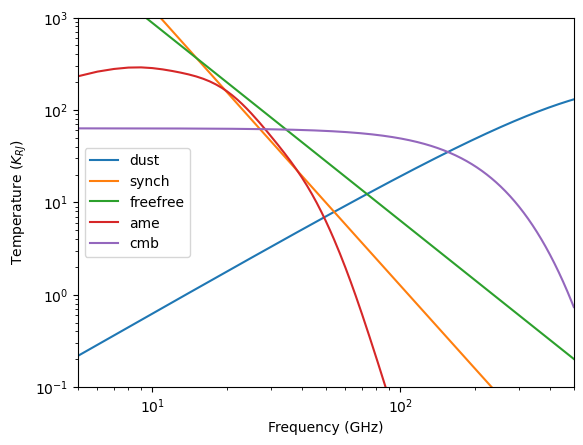

In [37]:
plt.figure()
var = 'T'
for k in spectrum2[var].keys():
    plt.plot(freqs, spectrum2[var][k], label=k)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Temperature ($K_{RJ}$)')
plt.legend()
plt.xlim([5,500])
plt.ylim([0.1,1000])
plt.show()

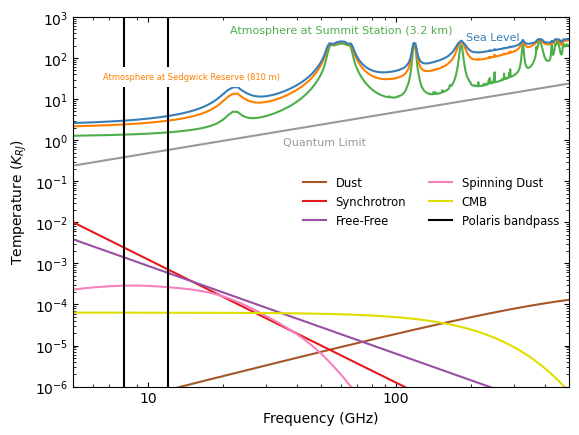

In [40]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(freq_summit, temp_summit, color='#4daf4a')#, label = 'Atmosphere at Summit Station (3.2 km)')
ax.plot(freq_sedgwick, temp_sedgwick, color='#ff7f00')#, label = 'Atmosphere at Sedgwick Reserve (810 m)')
ax.plot(freq_sea_level, temp_sea_level, color='#377eb8')#, label = 'Atmosphere Sea Level (0 m)')
ax.plot(freq_summit, ql, color='#999999')#, label = 'Quantum Limit')
ax.plot(freqs, 1e-6*spectrum2[var]['dust'], color='#a65628', label='Dust')
ax.plot(freqs, 1e-6*spectrum2[var]['synch'], color='#e41a1c', label='Synchrotron')
ax.plot(freqs, 1e-6*spectrum2[var]['freefree'], color='#984ea3', label='Free-Free')
ax.plot(freqs, 1e-6*spectrum2[var]['ame'], color ='#f781bf', label='Spinning Dust')
ax.plot(freqs, 1e-6*spectrum2[var]['cmb'], color='#dede00', label='CMB')
ax.axvline(x = 8, color = 'k', linestyle='-', label = 'Polaris bandpass')
ax.axvline(x = 12, color = 'k', linestyle='-')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Temperature ($K_{RJ}$)')
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(frameon=False, ncols=2, fontsize = 'small', loc='center right', framealpha=1)
ax.set_xlim([5,500])
ax.set_ylim([1e-6,1e3])
ax.tick_params(which = 'both', direction='in', bottom=True, top=True,left=True,right=True)
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.text(60,400, 'Atmosphere at Summit Station (3.2 km)', size = 8, horizontalalignment='center', color='#4daf4a')
plt.text(15,30, 'Atmosphere at Sedgwick Reserve (810 m)', size = 6, horizontalalignment='center', color='#ff7f00'
         , bbox=dict(facecolor='white', edgecolor='None'))
plt.text(245,270, 'Sea Level', size = 8, horizontalalignment='center', color='#377eb8')
plt.text(35,0.75, 'Quantum Limit', size = 8, horizontalalignment='left', color='#999999')
plt.show()
#plt.savefig('atmospheric_plot.png')